# Overview

This notebook uses a pre-trained language model to perform sentiment analysis on IMDB movie reviews using transfer learning.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.datasets import IMDB
from torch.optim import AdamW

from transformers import BertTokenizer, BertForSequenceClassification

import os
import random
import numpy as np

In [2]:
# Set a seed so that results can be reproduced
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)               # PyTorch CPU
    torch.cuda.manual_seed(seed)          # PyTorch GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Data

In [3]:
train_iter, test_iter = IMDB(split=('train', 'test'))
train_list = list(train_iter)

In [4]:
class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, text = self.data[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': 1 if label == 'pos' else 0
        }

In [5]:
train_pct = 0.8

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
imdb_dataset = IMDBDataset(train_list, tokenizer)

# Test dataset is used to evaluate final performance
test_dataset = IMDBDataset(list(test_iter), tokenizer)

train_size = int(0.8 * len(imdb_dataset))
valid_size = len(imdb_dataset) - train_size

train_dataset, valid_dataset = random_split(imdb_dataset, [train_size, valid_size])

# Train

In [6]:
# Parameters
batch_size = 32
epochs = 5

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
# Freeze parameters as we just want to fine tune the output layer
for param in model.bert.parameters():
    param.requires_grad = False

In [11]:
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [12]:
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    train_losses.append(train_loss/len(train_loader))
    
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            valid_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
        
    valid_losses.append(valid_loss/len(valid_loader))
    val_acc = correct/len(valid_loader.dataset)
    
    print(f"Epoch {epoch + 1}:\n\tTrain Loss = {train_losses[-1]:.4f}\n\tValid Loss = {valid_losses[-1]:.4f}")
    print(f"\tAccuracy: {val_acc}")

C:\Users\Aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1:
	Train Loss = 0.1670
	Valid Loss = 0.0285
	Accuracy: 0.999
Epoch 2:
	Train Loss = 0.0201
	Valid Loss = 0.0105
	Accuracy: 0.999
Epoch 3:
	Train Loss = 0.0086
	Valid Loss = 0.0059
	Accuracy: 0.999
Epoch 4:
	Train Loss = 0.0049
	Valid Loss = 0.0039
	Accuracy: 0.999
Epoch 5:
	Train Loss = 0.0036
	Valid Loss = 0.0026
	Accuracy: 0.9992


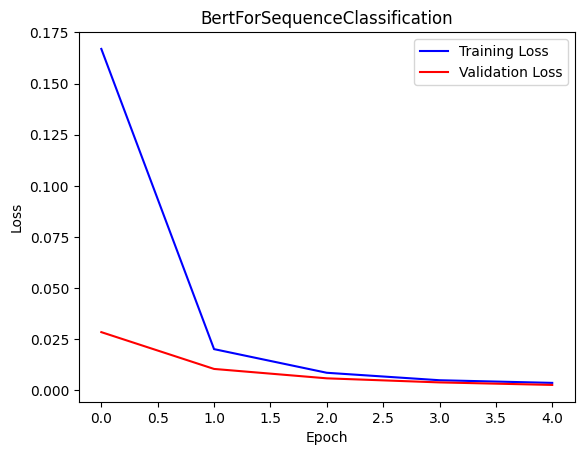

In [13]:
plt.title(model.__class__.__name__)
plt.plot(train_losses, color='blue', label='Training Loss')
plt.plot(valid_losses, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Evaluate the model on the test dataset (25000 entries)
model.eval()
correct = 0
total = 0
test_loss = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss     = {avg_test_loss:.4f}")
print(f"Test Accuracy = {test_accuracy*100:.2f}%")

Test Loss     = 0.0022
Test Accuracy = 99.98%


In [15]:
# Save the model
model.save_pretrained("./model")